Due to issues we've faced using Nexus for the challenge (in particular, regular misconnections in the Jupyter Notebooks), some of the code here has both a tket/Nexus based implementation and a local Qiskit implementation. Unfortunately, not all the results could be run using tket and Nexus. I've marked the source of the results along the notebook.

# Initial setup

## Packages

In [1]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

from pytket.circuit import Circuit, CircBox, QControlBox, Op, OpType, ConjugationBox
from pytket.circuit.display import render_circuit_jupyter
from pytket.passes import DecomposeBoxes
from pytket.extensions.qiskit import AerBackend, tk_to_qiskit

from math import log2
from jax import numpy as jnp
import phayes

from qiskit import QuantumCircuit, Aer, execute, transpile
from qiskit.quantum_info import Operator

from update_params import update_params

Run this to use Nexus.

In [2]:
#from pytket.extensions.nexus import NexusBackend, QuantinuumConfig, Nexus

## Backend

In [2]:
# Qiskit backend
backend = AerBackend()

In [4]:
# Nexus backend

phase_est_project = Nexus().new_project(f"Phase Estimation Tutorial - {datetime.now()}")

configuration = QuantinuumConfig(device_name="H1-1E")
#, user_group="iQuHACK_2024")

backend = NexusBackend(
    backend_config= configuration, 
    project= phase_est_project
)

NameError: name 'Nexus' is not defined

# General classes

## Simple $U$

The assume a 1-qubit unitary of the form:

$$
 \begin{equation}
U1(\phi) =
 \begin{pmatrix}
 1 & 0 \\
 0 & e^{i \pi \phi}
 \end{pmatrix}\, , \quad
 CU1(\phi) =
 \begin{pmatrix}
 1 & 0 & 0 & 0 \\
 0 & 1 & 0 & 0 \\
 0 & 0 & 1 & 0 \\
 0 & 0 & 0 & e^{i \pi \phi}
 \end{pmatrix}
 \end{equation}
$$

We wish to run a circuit of the form
$$H_aR_z(\theta)_aCU_{a,1}H_a$$

to implement the different variants of QPE.

Tket circuit to create simple 1-qubit U.

In [3]:
class bayesian_qpe_builder():
    
    def __init__(self, in_qubits, m_qubits, input_angle=1, z_angle=0, m=0, M=1):
        # Initializing the circuit.
        self.bayesian_qpe_circ: Circuit = Circuit()

        # Variables.
        self.m = m
        self.M = M
        self.use_M = True if M is not None else False
        if not self.use_M:
            self.M = 2**m
        self.in_qubits = in_qubits
        self.m_qubits = m_qubits
        self.input_angle = input_angle
        self.z_angle = z_angle
        
        # Creating the initial qubits.
        initial_state = Circuit(in_qubits).X(0)  # Initial state of the circuit (|psi>).

        # Creating the unitary gate.
        unitary_control = Circuit(m_qubits).U1(input_angle, 0)  # Unitary control gate.
        unitary_control.name = "U"
        controlled_u_gate = QControlBox(CircBox(unitary_control), 1)
        
        # Initiate the measurement qubit.
        measurement_register = self.bayesian_qpe_circ.add_q_register("|0>", m_qubits)
        # Initiate the initial state.
        state_prep_register = self.bayesian_qpe_circ.add_q_register("psi", in_qubits)

        # Adding tha Hadamard gate.
        for m_qubit in measurement_register:
            self.bayesian_qpe_circ.H(m_qubit)

        # Build the circuit.
        self.bayesian_qpe_circ.add_circuit(initial_state, list(state_prep_register))
        
        # Adding the U-Control gate.
        for m_qubit in range(m_qubits):
            control_index = m_qubits - m_qubit - 1 # Contrtoling the index of the qubit.
            control_qubit = [measurement_register[control_index]] # Controling WHICH qubit.
            for _ in range(self.M):
                self.bayesian_qpe_circ.add_qcontrolbox(
                    controlled_u_gate, control_qubit + list(state_prep_register)
                )

        # Adding the Rz and Hadamard.
        for m_qubit in measurement_register:
            self.bayesian_qpe_circ.Rz(z_angle, m_qubit)

        for m_qubit in measurement_register:
            self.bayesian_qpe_circ.H(m_qubit)

    def show_circuit(self):
        return render_circuit_jupyter(self.bayesian_qpe_circ)
            
        

Same circuit for Qiskit.

In [4]:
# Function to apply controlled-U operations
def apply_cu(qc, ctrl_qubit, target_qubit, U, power):
    U_cp = U.copy()
    U_cp.name = f"U^{2**power}"
    qc.append(U_cp.control(), [ctrl_qubit, target_qubit])

def qiskit_circuit(input_angle, M, angle, shots=10):
    # Define the unitary operator U. Here we use a Z gate as an example.
    U = QuantumCircuit(1)
    U.rz(np.pi*input_angle*M, 0)
    U.name = "U"

    # Number of iterations / precision bits
    num_iterations = 1

    # Prepare the quantum circuit
    qc = QuantumCircuit(2, 1)  # 2 qubits, 1 classical bit for measurement

    # Initialize the eigenstate of U (assuming |1> is an eigenstate of U)
    qc.x(1)  # Prepare the state |1>

    for k in range(num_iterations):
        # Apply Hadamard to auxiliary qubit
        qc.h(0)
        
        # Apply controlled-U operations conditioned on previous outcomes
        for i in range(2**k):
            apply_cu(qc, 0, 1, U, k)

        qc.rz(angle, 0)
        
        # Apply the inverse QFT (Hadamard for single qubit)
        qc.h(0)
        
        # Measure
        qc.measure(0, 0)
        
        # Execute the circuit
        backend = Aer.get_backend('qasm_simulator')
        job = execute(qc, backend, shots=shots)
        result = job.result()
        measurement = result.get_counts()

        #print(qc.draw())

        return measurement

    # The estimated phase would be determined here based on the measurements

In [2]:
#bayesian_qpe = bayesian_qpe_builder(1, 1, input_angle=0.1, z_angle=0.5, m=0)
#bayesian_qpe.show_circuit()

## General $U$ for Hamiltonian simulation

Beyond the simple 1-qubit $U$, we also consider a more general and practical setting, based on the paper: https://arxiv.org/pdf/2310.12256.pdf
We implement the decomposition of a 4-qubit U into simpler components, which can be used to more efficiently implement QPE.

In [3]:
def unitary(m, angle):
    theta_1=0.5
    theta_2=0.7
    theta_3=0.2
    # Define the angles for the rotations
    Rz_op = lambda angle0: Op.create(OpType.Rz, angle0)
    Conz0=QControlBox(Rz_op(theta_1),n_controls=3,control_state=[0,1,2])
    Conz1=QControlBox(Rz_op(theta_2),n_controls=3,control_state=[0,1,2])
    Conz2=QControlBox(Rz_op(theta_3),n_controls=3,control_state=[0,1,2])
    
    A=Circuit(4)
    A.add_gate(Conz0,[2,0,1,3])
    A.add_gate(Conz1,[1,0,2,3])
    A.add_gate(Conz2,[0,1,2,3])

    B=Circuit(4)
    for i in range(m):
        B.add_gate(CircBox(A),[0,1,2,3])

    C=Circuit(4)
    C.CX(2, 3)
    # Assuming the first three steps include another CNOT from qubit 1 to qubit 2
    C.CX(1, 3)
    # And one more CNOT from qubit 0 to qubit 1
    C.CX(0, 3)
    C.H(3)

    c_box = CircBox(C)
    b_box= CircBox(B)
    conj_box=ConjugationBox(c_box,b_box)

    circ=Circuit(4)
    circ.add_gate(conj_box,[0,1,2,3])

    finalu=QControlBox(conj_box,n_controls=1,control_state=[0])

    circ=Circuit(5,1)
    circ.H(0)
    circ.add_gate(finalu,[0,1,2,3,4])
    circ.Rz(angle,0)
    circ.H(0)
    circ.Measure(0,0)
    return circ
    

In [6]:
circ = unitary(3, 1.)
DecomposeBoxes().apply(circ)
render_circuit_jupyter(circ)

Qiskit version

In [5]:
theta_1=0.5
theta_2=0.7
theta_3=0.2
# Define the angles for the rotations
Rz_op = lambda angle: Op.create(OpType.Rz, angle)
Conz0=QControlBox(Rz_op(theta_1),n_controls=3,control_state=[0,1,2])
Conz1=QControlBox(Rz_op(theta_2),n_controls=3,control_state=[0,1,2])
Conz2=QControlBox(Rz_op(theta_3),n_controls=3,control_state=[0,1,2])

A=Circuit(4)

A.add_gate(Conz0,[2,0,1,3])
A.add_gate(Conz1,[1,0,2,3])
A.add_gate(Conz2,[0,1,2,3])

#render_circuit_jupyter(A)
C=Circuit(4)

C.CX(2, 3)
# Assuming the first three steps include another CNOT from qubit 1 to qubit 2
C.CX(1, 3)
# And one more CNOT from qubit 0 to qubit 1
C.CX(0, 3)
C.H(3)
#render_circuit_jupyter(C)
c_box = CircBox(C)
a_box= CircBox(A)
conj_box=ConjugationBox(c_box,a_box)
circ=Circuit(4)
circ.add_gate(conj_box,[0,1,2,3])

#render_circuit_jupyter(circ)
finalu=QControlBox(conj_box,n_controls=1,control_state=[0])
circ=Circuit(5)
circ.add_gate(finalu,[0,1,2,3,4])


#render_circuit_jupyter(circ)
DecomposeBoxes().apply(circ)
cU = tk_to_qiskit(circ)
cU.name = 'cU'

DecomposeBoxes().apply(A)
A = tk_to_qiskit(A)
A.name = 'A'

DecomposeBoxes().apply(C)
C = tk_to_qiskit(C)
C.name = 'c_box'


In [6]:
# Function to apply controlled-U operations
def apply_big_cu(qc, ctrl_qubit, target_qubits, U, power):
    U_cp = U.copy()
    U_cp.name = f"U^{2**power}"
    qc.append(U_cp.control(), [ctrl_qubit, *target_qubits])

def qiskit_circuit_big_U(cU, M, angle, shots=10):

    # Prepare the quantum circuit
    qc = QuantumCircuit(5, 1)  # 2 qubits, 1 classical bit for measurement

    # Initialize the eigenstate of U (assuming |1> is an eigenstate of U)
    # qc.x(1)  # Prepare the state |1>

    for k in range(1):
        # Apply Hadamard to auxiliary qubit
        qc.h(0)

        # Apply controlled-U operations conditioned on previous outcomes
        for i in range(M):
            qc.append(cU, range(5))

        qc.rz(angle, 0)
        
        # Apply the inverse QFT (Hadamard for single qubit)
        qc.h(0)
        
        # Measure
        qc.measure(0, 0)

        #print(qc.draw())
        
        # Execute the circuit
        backend = Aer.get_backend('qasm_simulator')
        job = execute(qc, backend, shots=shots)
        result = job.result()
        measurement = result.get_counts()

        #print(qc.draw())

        return measurement

def qiskit_circuit_big_A(A, M, angle, shots=10):

    # Prepare the quantum circuit
    qc = QuantumCircuit(5, 1)  # 2 qubits, 1 classical bit for measurement

    # Initialize the eigenstate of U (assuming |1> is an eigenstate of U)
    # qc.x(1)  # Prepare the state |1>

    qcA = QuantumCircuit(4)

    qcA.append(C, range(4))
        
    # Apply controlled-U operations conditioned on previous outcomes
    for i in range(M):
        qcA.append(A, range(4))

    qcA.append(C.inverse(), range(4))

    for k in range(1):
        # Apply Hadamard to auxiliary qubit
        qc.h(0)

        apply_big_cu(qc, 0, [1,2,3,4], qcA, M)

        qc.rz(angle, 0)
        
        # Apply the inverse QFT (Hadamard for single qubit)
        qc.h(0)
        
        # Measure
        qc.measure(0, 0)

        #print(qc.draw())
        
        # Execute the circuit
        backend = Aer.get_backend('qasm_simulator')
        job = execute(qc, backend, shots=shots)
        result = job.result()
        measurement = result.get_counts()

        #print(qc.draw())

        return measurement

# Iterative QPE

Here we implement iterative QPE. Infortunately, it's appears that we introduced some bug into the code in the final hours of the challenge, and we weren't able to discover the error. Previously, the method was exact in the noiseless setting for phases that can be expressed exactly in binary.

In [7]:
class iterative_phase_estimation():
    """
    A class to perform iterative phase estimation algorithm.
    
    This class estimates the phase of a quantum state using the iterative phase estimation algorithm. 
    The algorithm iteratively refines the estimate of the phase by adjusting the measurement basis 
    and interpreting the measurement outcomes.
    
    Attributes:
        M_0 (int): Initial value of M, controls the precision of the phase estimation.
        z_angle_0 (float): Initial z-axis rotation angle.
        precision (int): The number of bits of precision for the phase estimate.
        backend: The quantum computation backend to run circuits.
    """

    def __init__(self, M_0=None, z_angle_0=None, precision=3, backend=None):
        """
        Initializes the iterative phase estimation algorithm with optional parameters.
        
        Parameters:
            M_0 (int, optional): The starting value of M. Defaults to 2**(precision-1) if None.
            z_angle_0 (float, optional): The starting z-axis angle for rotation. Defaults to 0 if None.
            precision (int, optional): The desired precision for the phase estimate. Defaults to 3.
            backend: The backend to execute quantum circuits. Defaults to None.
        """
        self.M_0 = M_0 if M_0 is not None else 2**(precision-1)
        self.z_angle_0 = z_angle_0 if z_angle_0 is not None else 0.
        self.M_list = [self.M_0]  # Tracks the M values used in each iteration.
        self.angle_list = [self.z_angle_0]  # Tracks the angles used in each iteration.
        self.precision = precision
        self.phi_list = []  # Tracks the phi values obtained in each iteration.
        self.backend = backend

    def next_params(self):
        """
        Calculates the next parameters (M and angle) for the iteration based on the latest phi value.
        
        Parameters:
            phi (int): The phi value obtained from the latest quantum measurement.
        
        Returns:
            tuple: A tuple containing the new M value and the new angle for the next iteration.
        """
        last_M, last_angle = self.M_list[-1], self.angle_list[-1]
        precision = self.precision
        n_updates = len(self.M_list)

        new_M = 2**(precision - n_updates - 1)

        int_list = 2**(-np.arange(1, precision + 1, 1)[::-1].astype(float))
        new_angle = -np.pi * np.sum(int_list[:n_updates] * self.phi_list)

        self.M_list.append(new_M)
        self.angle_list.append(new_angle)

        return new_M, new_angle

    def next_phi(self, circuit):
        """
        Processes the given circuit to extract the next phi value.
        
        This method involves compiling the circuit for the backend, executing it, 
        and interpreting the result to obtain phi.
        
        Parameters:
            circuit: The quantum circuit to be processed.
        
        Returns:
            int: The new phi value extracted from the circuit execution result.
        """
        # Assuming DecomposeBoxes is a method or class available in the context for circuit processing.
        DecomposeBoxes().apply(circuit)
        compiled_circ = self.backend.get_compiled_circuit(circuit)
        n_shots = 16  # The number of shots for the circuit execution.
        result = self.backend.run_circuit(compiled_circ, n_shots)
        print(result.get_counts())
        for key, val in result.get_counts().items():
            meas = key[1]
            if meas==0:
                P_0 = val/n_shots
                P_1 = 1-P_0
            elif meas==1:
                P_1 = val/n_shots
                P_0 = 1-P_1
        
        new_phi = 0 if P_0 > P_1 else 1

        self.phi_list.append(new_phi)
        return new_phi

    def next_phi_qiskit(self, measurement):
        """
        Processes the given circuit to extract the next phi value.
        
        This method involves compiling the circuit for the backend, executing it, 
        and interpreting the result to obtain phi.
        
        Parameters:
            circuit: The quantum circuit to be processed.
        
        Returns:
            int: The new phi value extracted from the circuit execution result.
        """
        n_shots=1

        meas = int(list(measurement)[0])
        val = list(measurement.values())[0]
        if meas==0:
            P_0 = val/n_shots
            P_1 = 1-P_0
        elif meas==1:
            P_1 = val/n_shots
            P_0 = 1-P_1
        new_phi = 0 if P_0 > P_1 else 1
        self.phi_list.append(new_phi)
        return new_phi

    def get_final_estimate(self):
        """
        Calculates the final phase estimate after all iterations.
        
        Returns:
            float: The final estimate of the phase.
        """
        precision = self.precision
        n_updates = len(self.M_list)
        int_list = 2**(-np.arange(0, precision, 1)[::-1].astype(float))
        final_angle = np.pi * np.sum(int_list[:n_updates] * self.phi_list)
        self.final_angle = final_angle
        return final_angle*2/np.pi


Get estimate using IQPE.

In [108]:
def get_estimate(input_angle, precision, format='tket'):
    IQPE = iterative_phase_estimation(precision=precision, backend=backend)
    for i in range(IQPE.precision):
        M, angle = IQPE.M_list[-1], IQPE.angle_list[-1]
        m = int(log2(M))
        print(M, angle, m)
        if format=='tket':
            circuit = bayesian_qpe_builder(1, 1, input_angle=input_angle, z_angle=angle, m=m).bayesian_qpe_circ.measure_all()
            phi = IQPE.next_phi(circuit)
        elif format=='qiskit':
            measurement = qiskit_circuit(input_angle=input_angle, M=int(M), angle=float(angle), shots=1)
            phi = IQPE.next_phi_qiskit(measurement)
        print(IQPE.phi_list)
        if i < IQPE.precision - 1:
            IQPE.next_params()
    return IQPE.get_final_estimate()

Plot error vs iteration.

In [116]:
get_estimate(0.25, 12, format='qiskit')

2048 0.0 11
[0]
1024 -0.0 10
[0, 0]
512 -0.0 9
[0, 0, 0]
256 -0.0 8
[0, 0, 0, 0]
128 -0.0 7
[0, 0, 0, 0, 0]
64 -0.0 6
[0, 0, 0, 0, 0, 0]
32 -0.0 5
[0, 0, 0, 0, 0, 0, 0]
16 -0.0 4
[0, 0, 0, 0, 0, 0, 0, 0]
8 -0.0 3
[0, 0, 0, 0, 0, 0, 0, 0, 1]
4 -0.19634954084936207 2
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
2 -0.19634954084936207 1
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]
1 -0.9817477042468103 0
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


1.25

2 0.0 1
[0]
1 -0.0 0
[0, 0]
4 0.0 2
[1]
2 -0.39269908169872414 1
[1, 0]
1 -0.39269908169872414 0
[1, 0, 0]
8 0.0 3
[1]
4 -0.19634954084936207 2
[1, 0]
2 -0.19634954084936207 1
[1, 0, 0]
1 -0.19634954084936207 0
[1, 0, 0, 0]
16 0.0 4
[1]
8 -0.09817477042468103 3
[1, 1]
4 -0.2945243112740431 2
[1, 1, 0]
2 -0.2945243112740431 1
[1, 1, 0, 0]
1 -0.2945243112740431 0
[1, 1, 0, 0, 0]
32 0.0 5
[0]
16 -0.0 4
[0, 1]
8 -0.09817477042468103 3
[0, 1, 0]
4 -0.09817477042468103 2
[0, 1, 0, 0]
2 -0.09817477042468103 1
[0, 1, 0, 0, 0]
1 -0.09817477042468103 0
[0, 1, 0, 0, 0, 0]
64 0.0 6
[0]
32 -0.0 5
[0, 0]
16 -0.0 4
[0, 0, 1]
8 -0.09817477042468103 3
[0, 0, 1, 0]
4 -0.09817477042468103 2
[0, 0, 1, 0, 0]
2 -0.09817477042468103 1
[0, 0, 1, 0, 0, 0]
1 -0.09817477042468103 0
[0, 0, 1, 0, 0, 0, 0]
128 0.0 7
[0]
64 -0.0 6
[0, 0]
32 -0.0 5
[0, 0, 0]
16 -0.0 4
[0, 0, 0, 1]
8 -0.09817477042468103 3
[0, 0, 0, 1, 1]
4 -0.2945243112740431 2
[0, 0, 0, 1, 1, 0]
2 -0.2945243112740431 1
[0, 0, 0, 1, 1, 0, 0]
1 -0.294

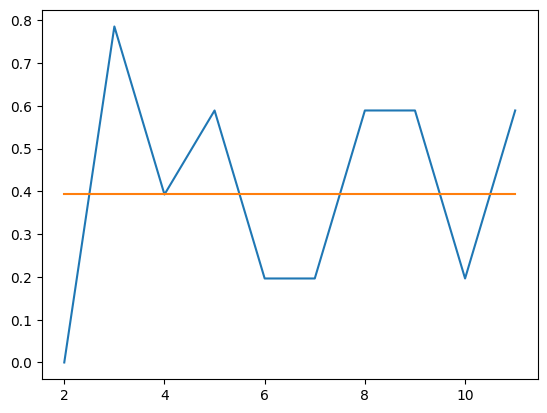

In [91]:
input_angle = 0.125
precisions = np.arange(2,12)
data = [get_estimate(input_angle, precision, format='qiskit') for precision in precisions]
plt.plot(precisions, data)
plt.plot(precisions, input_angle*np.pi*(1+np.zeros_like(precisions)))
plt.show()

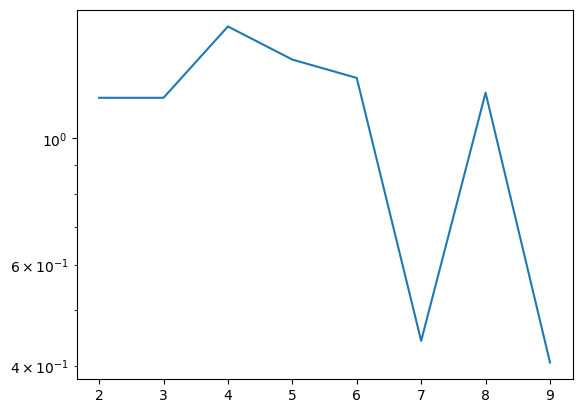

In [37]:
plt.plot(precisions, np.abs(data-input_angle*np.pi*(1+np.zeros_like(precisions))))
plt.yscale('log')
plt.show()

# Bayesian QPE

Here we implement bayesian QPE. We also introduce an optional limit to the exponent that can be used, which is effectively a limit on the circuit depth. This has papers with $\alpha$-QPE, which is a generalization of Bayesian QPE. See https://arxiv.org/pdf/2207.14810.pdf, https://arxiv.org/pdf/1802.00171.pdf

In [6]:
class alpha_phase_estimation():
    """
    A class to perform alpha phase estimation algorithm.
    
    This class estimates the phase of a quantum state using the iterative phase estimation algorithm. 
    The algorithm iteratively refines the estimate of the phase by adjusting the measurement basis 
    and interpreting the measurement outcomes.
    
    Attributes:
        M_0 (int): Initial value of M, controls the precision of the phase estimation.
        z_angle_0 (float): Initial z-axis rotation angle.
        precision (int): The number of bits of precision for the phase estimate.
        backend: The quantum computation backend to run circuits.
    """

    def __init__(self, s=100, M_max=1e100, backend=None):
        """
        Initializes the iterative phase estimation algorithm with optional parameters.
        
        Parameters:
            M_0 (int, optional): The starting value of M. Defaults to 2**(precision-1) if None.
            z_angle_0 (float, optional): The starting z-axis angle for rotation. Defaults to 0 if None.
            precision (int, optional): The desired precision for the phase estimate. Defaults to 3.
            backend: The backend to execute quantum circuits. Defaults to None.
        """
        self.phi_list = []  # Tracks the phi values obtained in each iteration.
        self.backend = backend
        self.phi_arr = np.linspace(-np.pi, np.pi, 1024)
        self.s = s
        self.posterior_state = phayes.init()
        self.errors = []
        self.M_max = M_max
            
    def normal_dist(self, mu, sigma):
        return np.exp(-0.5*((self.phi_arr - mu) / sigma)**2)

    # def params(self):
    #     mu, sigma = self.mu_list[-1], self.sigma_list[-1]
    #     M = max(1, int(1./sigma))
    #     angle = mu-sigma
    #     return M, angle

    def next_phi(self, circuit):
        """
        Processes the given circuit to extract the next phi value.
        
        This method involves compiling the circuit for the backend, executing it, 
        and interpreting the result to obtain phi.
        
        Parameters:
            circuit: The quantum circuit to be processed.
        
        Returns:
            int: The new phi value extracted from the circuit execution result.
        """
        # Assuming DecomposeBoxes is a method or class available in the context for circuit processing.
        DecomposeBoxes().apply(circuit)
        compiled_circ = self.backend.get_compiled_circuit(circuit)
        n_shots = self.s  # The number of shots for the circuit execution.
        result = self.backend.run_circuit(compiled_circ, n_shots)

        #print(result.get_counts())
        for i, (key, val) in enumerate(result.get_counts().items()):
            meas = key[-1]
            meas_arr = np.zeros(self.s, dtype=int)
            meas_arr[:val] = meas
            meas_arr[val:] = 1-meas
            M, beta = phayes.get_k_and_beta(self.posterior_state)
            self.posterior_state = phayes.update(self.posterior_state, meas_arr, M, beta)
            if M > self.M_max:
                beta = phayes.get_beta_given_k(self.posterior_state, self.M_max)[0]
                self.posterior_state = phayes.update(self.posterior_state, meas_arr, self.M_max, beta)
            else:
                self.posterior_state = phayes.update(self.posterior_state, meas_arr, M, beta)
            if i>0:
                break
            
        # meas = int(list(measurement)[0])
        # val = list(measurement.values())[0]
        # meas_arr = np.zeros(self.s, dtype=int)
        # meas_arr[:val] = meas
        # meas_arr[val:] = 1-meas
        # #print(meas_arr)
        # M, beta = phayes.get_k_and_beta(self.posterior_state)
        # self.posterior_state = phayes.update(self.posterior_state, meas_arr, M, beta)

    def next_phi_qiskit(self, measurement):
        """
        Processes the given circuit to extract the next phi value.
        
        This method involves compiling the circuit for the backend, executing it, 
        and interpreting the result to obtain phi.
        
        Parameters:
            circuit: The quantum circuit to be processed.
        
        Returns:
            int: The new phi value extracted from the circuit execution result.
        """


        meas = int(list(measurement)[0])
        val = list(measurement.values())[0]
        meas_arr = np.zeros(self.s, dtype=int)
        meas_arr[:val] = meas
        meas_arr[val:] = 1-meas
        #print(meas_arr)
        M, beta = phayes.get_k_and_beta(self.posterior_state)
        if M > self.M_max:
            beta = phayes.get_beta_given_k(self.posterior_state, self.M_max)[0]
            self.posterior_state = phayes.update(self.posterior_state, meas_arr, self.M_max, beta)
        else:
            self.posterior_state = phayes.update(self.posterior_state, meas_arr, M, beta)

    def get_final_estimate(self):
        """
        Calculates the final phase estimate after all iterations.
        
        Returns:
            float: The final estimate of the phase.
        """
        
        final_angle = float(phayes.circular_mean(self.posterior_state)) * 2 / np.pi
        self.final_angle = final_angle
        return final_angle

    def get_final_error(self, val):
        """
        Calculates the final phase estimate after all iterations.
        
        Returns:
            float: The final estimate of the phase.
        """
        
        error = float(phayes.cosine_distance(val, self.posterior_state))
        self.errors.append(error)


In [118]:
# def get_estimate_alpha(input_angle, precision):
#     AQPE = alpha_phase_estimation(mu=0.5, sigma=0.4, s=10, precision=precision, backend=backend)
#     for i in range(4):
#         M, beta = phayes.get_k_and_beta(AQPE.posterior_state)
#         angle = beta
#         #m = int(log2(M))
#         print("M, angle:", M, angle)
#         if i%1==0:
#             plt.plot(AQPE.phi_arr, phayes.pdf(AQPE.phi_arr, AQPE.posterior_state), label=i)
#         circuit = bayesian_qpe_builder(1, 1, input_angle=input_angle, z_angle=angle/np.pi, M=M).bayesian_qpe_circ.measure_all()
#         AQPE.next_phi(circuit)
#         #measurement = qiskit_circuit(input_angle=input_angle, M=int(M), angle=float(angle))
#         #AQPE.next_phi_qiskit(measurement)
#     plt.legend()
#     plt.show()
#     return AQPE.get_final_estimate()

In [3]:
# get_estimate_alpha(0.5, 10)

Get estimate from Bayesian QPE.

In [7]:
def get_estimate_bayesian(input_angle, iters=10, s=10, M_max=1e10, format='tket', U='small'):
    final_angles = []
    AQPE = alpha_phase_estimation(s=s, M_max=M_max, backend=backend)
    for i in range(iters):
        M, beta = phayes.get_k_and_beta(AQPE.posterior_state)
        if M > AQPE.M_max:
            M = AQPE.M_max
            beta = phayes.get_beta_given_k(AQPE.posterior_state, M)[0]

        angle = beta
        #m = int(log2(M))
        print("M, angle:", M, angle)
        plt.plot(AQPE.phi_arr, phayes.pdf(AQPE.phi_arr, AQPE.posterior_state), label=i)
        final_angles.append(AQPE.get_final_estimate())
        AQPE.get_final_error(input_angle  * np.pi / 2)
        if U=='small':
            if format=='tket':
                circuit = bayesian_qpe_builder(1, 1, input_angle=input_angle, z_angle=angle/np.pi, M=int(M)).bayesian_qpe_circ.measure_all()
                AQPE.next_phi(circuit)
            elif format=='qiskit':
                measurement = qiskit_circuit(input_angle=input_angle, M=int(M), angle=float(angle), shots=s)
                AQPE.next_phi_qiskit(measurement)
        elif U=='naive':
            if format=='qiskit':
                measurement = qiskit_circuit_big_U(cU, M=int(M), angle=float(angle), shots=s)
                AQPE.next_phi_qiskit(measurement)
        elif U=='fast':
            if format=='qiskit':
                measurement = qiskit_circuit_big_A(A, M=int(M), angle=float(angle), shots=s)
                AQPE.next_phi_qiskit(measurement)
            elif format=='tket':
                circuit = unitary(int(M), float(angle))
                AQPE.next_phi(circuit)
    plt.legend()
    plt.show()
    errors = AQPE.errors
    return final_angles, errors

M, angle: 1 1.5707964
M, angle: 2 1.5707964
M, angle: 7 2.675704
M, angle: 11 1.9732544
M, angle: 28 1.5707964
M, angle: 5 0.0
M, angle: 96 1.4384335


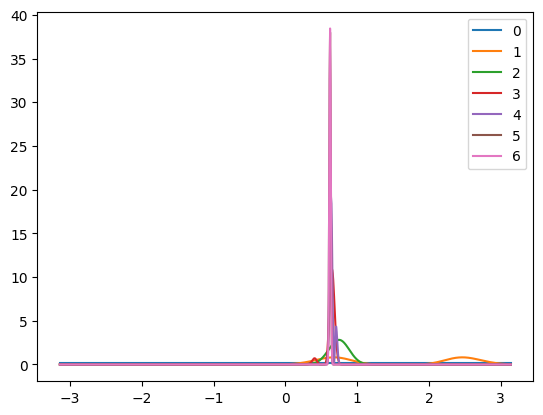

M, angle: 1 1.5707964
M, angle: 4 1.5707964
M, angle: 16 1.2103938
M, angle: 24 2.1940272
M, angle: 225 0.0
M, angle: 140 1.5708158
M, angle: 33 0.0


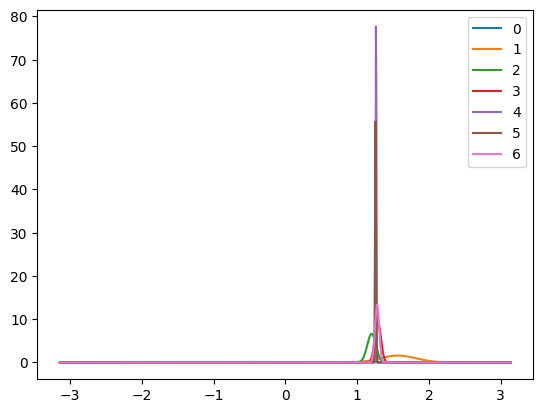

In [53]:
final_angles, errors_small = get_estimate_bayesian(0.4, iters=7, s=16, format='qiskit', U='small')
final_angles, errors_small_tket = get_estimate_bayesian(0.4, iters=7, s=16, format='tket', U='small')

Comparison of Qiskit and tket implementations (noiseless). The tket implementation appears to have run into numerical bugs.

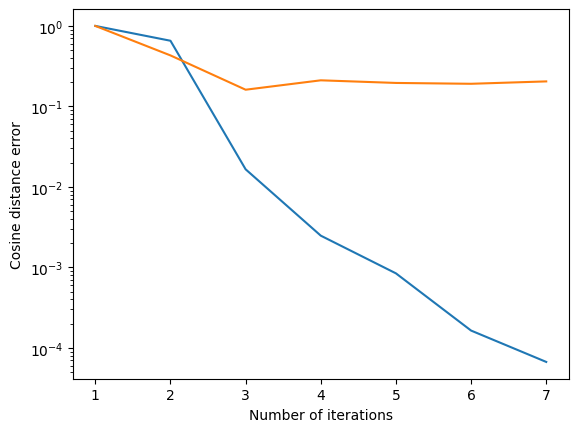

In [56]:
iters = np.arange(1, len(errors_small)+1)
plt.plot(iters, np.abs(errors_small), label='1-qubit qiskit')
plt.plot(iters, np.abs(errors_small_tket), label='1-qubit tket')
plt.yscale('log')
plt.xlabel(r'Number of iterations')
plt.ylabel(r'Cosine distance error')
plt.show()

M, angle: 1 1.5707964
M, angle: 2 1.5707964
M, angle: 5 0.79863894
M, angle: 6 1.8229517
M, angle: 20 2.651299
M, angle: 20 1.5707964
M, angle: 12 2.0681417


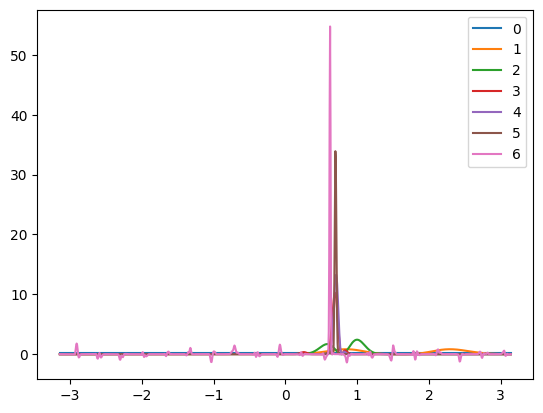

M, angle: 1 1.5707964
M, angle: 4 1.5707964
M, angle: 16 1.2103938
M, angle: 20 0.0
M, angle: 20 0.0
M, angle: 20 0.0
M, angle: 20 0.0


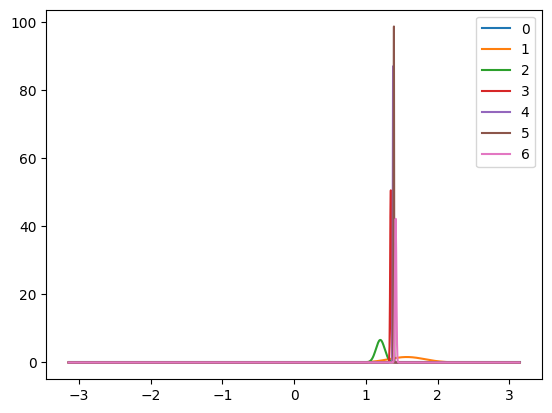

In [73]:
final_angles, errors_small_20 = get_estimate_bayesian(0.4, iters=7, s=16, M_max=20, format='qiskit', U='small')
final_angles, errors_small_tket_20 = get_estimate_bayesian(0.4, iters=7, s=16, M_max=20, format='tket', U='small')

M, angle: 1 1.5707964
M, angle: 1 0.0
M, angle: 7 2.828422
M, angle: 12 1.8952659
M, angle: 46 1.4412698
M, angle: 100 1.252808
M, angle: 0 1.5707964


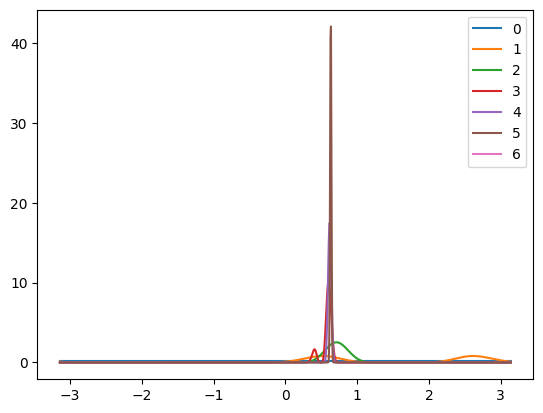

M, angle: 1 1.5707964
M, angle: 4 1.5707964
M, angle: 16 1.2103938
M, angle: 68 1.6824393
M, angle: 100 0.0
M, angle: 100 1.32303
M, angle: 100 1.8133509


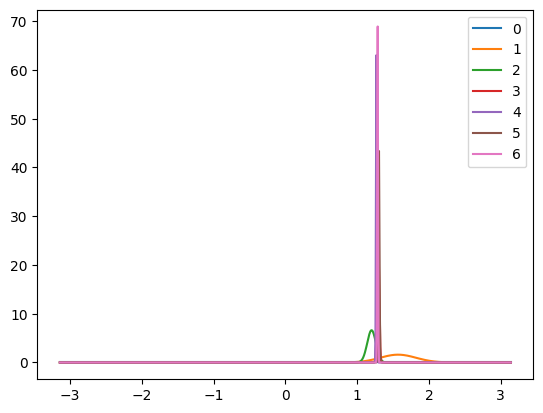

In [76]:
final_angles, errors_small_100 = get_estimate_bayesian(0.4, iters=7, s=16, M_max=100, format='qiskit', U='small')
final_angles, errors_small_tket_100 = get_estimate_bayesian(0.4, iters=7, s=16, M_max=100, format='tket', U='small')

Comparison between normal Bayesian QPE, Bayesian QPE with $M=20$ and $M=100$. As expected, low $M$ limit leads to higher error, which should be compensated with more measurements.

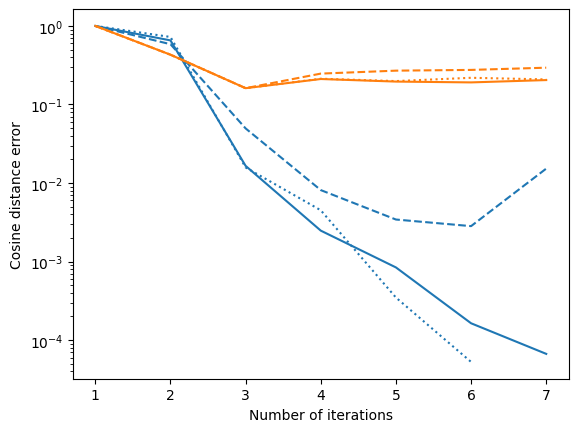

In [77]:
iters = np.arange(1, len(errors_small)+1)
iters = np.arange(1, len(errors_small)+1)
plot = plt.plot(iters, np.abs(errors_small), label='1-qubit qiskit')
plt.plot(iters, np.abs(errors_small_20), '--', color=plot[-1].get_color())
plt.plot(iters, np.abs(errors_small_100), ':', color=plot[-1].get_color())
plot = plt.plot(iters, np.abs(errors_small_tket), label='1-qubit tket')
plt.plot(iters, np.abs(errors_small_tket_20), '--', color=plot[-1].get_color())
plt.plot(iters, np.abs(errors_small_tket_100), ':', color=plot[-1].get_color())
plt.yscale('log')
plt.xlabel(r'Number of iterations')
plt.ylabel(r'Cosine distance error')
plt.show()

In [8]:
final_angles, errors_fast_20 = get_estimate_bayesian(0.25, iters=7, s=16, M_max=20, format='tket', U='fast')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


M, angle: 1 1.5707964
M, angle: 1 1.6031823


M, angle: 1 1.5707964
M, angle: 1 0.0
M, angle: 5 2.8109312
M, angle: 11 1.0231717
M, angle: 23 0.2321708
M, angle: 85 0.0
M, angle: 489 2.3248887


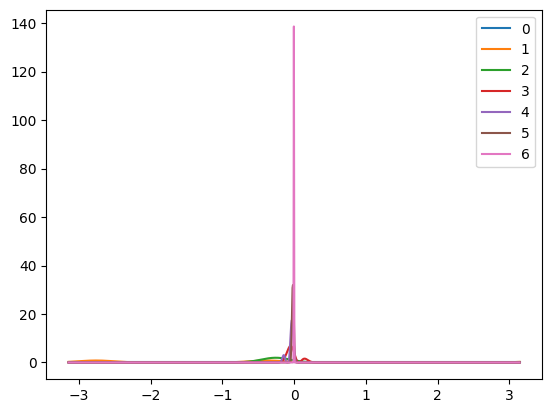

In [71]:
#final_angles, errors_fast = get_estimate_bayesian(0.25, iters=7, s=16, format='qiskit', U='fast')
final_angles, errors_naive = get_estimate_bayesian(0.25, iters=7, s=16, format='qiskit', U='naive')

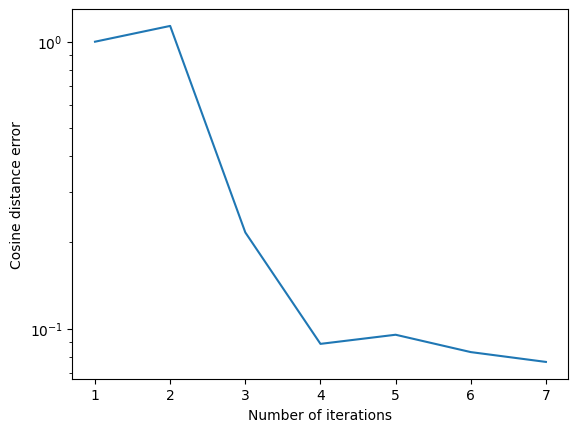

In [72]:
iters = np.arange(1, len(errors_naive)+1)
plt.plot(iters, np.abs(errors_naive), label='4-qubit naive')
#plt.plot(iters, np.abs(errors_fast), label='4-qubit fast')
plt.yscale('log')
plt.xlabel(r'Number of iterations')
plt.ylabel(r'Cosine distance error')
plt.show()

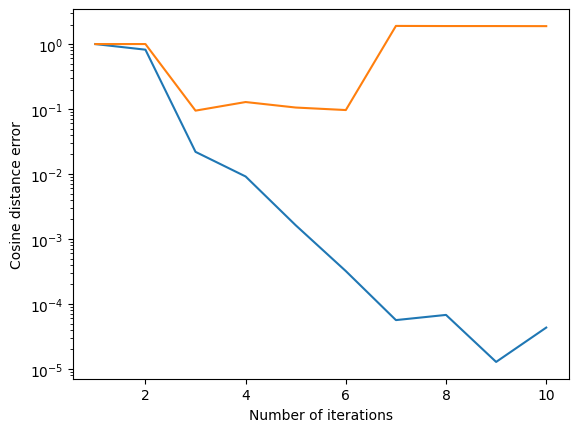

In [52]:
iters = np.arange(1, len(errors_small)+1)
plt.plot(iters, np.abs(errors_small), label='1-qubit U')
plt.plot(iters, np.abs(errors_big), label='4-qubit U')
plt.yscale('log')
plt.xlabel(r'Number of iterations')
plt.ylabel(r'Cosine distance error')
plt.show()

# Analysis of general $U$

In [45]:
def vec_to_dirac(vector, threshold=1e-6):
    """
    Converts a vector representing a quantum state into Dirac notation.

    Parameters:
    - vector: numpy array, the vector to be converted.
    - threshold: float, the minimum absolute value for coefficients to be included.

    Returns:
    - A string representing the vector in Dirac notation.
    """
    # Determine the number of qubits from the vector length
    num_qubits = int(np.log2(len(vector)))
    dirac_notation = ""
    
    for i, amplitude in enumerate(vector):
        # Skip amplitudes below the threshold
        if np.abs(amplitude) > threshold:
            # Convert the index to binary and format it as a basis state
            basis_state = format(i, f'0{num_qubits}b')
            # Add the term to the Dirac notation string
            amplitude_str = f"{amplitude:.2f}" if np.imag(amplitude) == 0 else f"({amplitude:.2f})"
            dirac_notation += f"{amplitude_str}|{basis_state}> + "
    
    # Remove the last ' + ' if the string is not empty
    if dirac_notation:
        dirac_notation = dirac_notation[:-3]
    
    return dirac_notation

In [43]:
# Use Aer's unitary simulator to simulate the circuit
backend = Aer.get_backend('unitary_simulator')
job = backend.run(transpile(cU, backend))
unitary = job.result().get_unitary(cU)

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(unitary)

print("Eigenvalues:", eigenvalues)
print("Eigenvectors:", eigenvectors)

Eigenvalues: [1.        -2.10942375e-15j 1.        -3.08086889e-15j
 1.        -7.74580024e-17j 1.        -1.73472348e-16j
 1.        -1.86482774e-16j 1.        +1.11022302e-16j
 1.        -3.05311332e-16j 0.70710678-7.07106781e-01j
 0.70710678+7.07106781e-01j 0.4539905 +8.91006524e-01j
 0.4539905 -8.91006524e-01j 0.95105652-3.09016994e-01j
 0.95105652+3.09016994e-01j 1.        -9.36750677e-17j
 1.        -1.85615412e-16j 1.        -3.06937635e-16j
 1.        -1.60353501e-16j 1.        -3.21964677e-15j
 1.        -2.08166817e-15j 1.        -5.55111512e-17j
 1.        -2.64718802e-15j 1.        -2.08513762e-15j
 1.        -9.02056208e-17j 1.        -2.77555756e-15j
 1.        -2.49800181e-16j 1.        -3.01841885e-15j
 1.        -1.84921523e-15j 1.        -1.38777878e-17j
 1.        -2.33146835e-15j 1.        -1.94289029e-16j
 1.        -1.11022302e-16j 1.        -5.55111512e-17j]
Eigenvectors: [[ 7.32130177e-01+0.00000000e+00j  6.93163548e-01-5.89489014e-02j
   8.03832179e-03+5.289728

In [ ]:
phases = np.angle(eigenvalues)

# Round small angles to zero
phases_rounded = np.where(np.abs(phases) < 1e-5, 0, phases)

# Compute the eigenvalues of the Hamiltonian with rounded phases
hamiltonian_eigenvalues_rounded = phases_rounded

hamiltonian_eigenvalues_rounded

In [48]:
for eigenvector in eigenvectors:
    print(vec_to_dirac(eigenvector, threshold=1e-2))

0.73+0.00j|00000> + (0.69-0.06j)|00001>
1.00+0.00j|00010> + (-0.06-0.01j)|00011> + (-0.13+0.01j)|00100> + (-0.01-0.01j)|00101> + (0.01+0.01j)|00110>
(-0.01+0.01j)|10001> + (0.02-0.01j)|10010> + (0.02-0.05j)|10011> + (-0.15-0.21j)|10100> + (-0.14+0.12j)|10101> + (0.00-0.09j)|10110> + (-0.52+0.12j)|10111> + (-0.06+0.02j)|11000> + (-0.50-0.10j)|11001> + (0.33-0.23j)|11010> + (-0.02-0.06j)|11011> + (0.16-0.27j)|11100> + (0.01+0.01j)|11110> + (0.01+0.01j)|11111>
0.71+0.00j|00011> + 0.87+0.00j|00100> + (0.11+0.01j)|00101> + (0.04-0.16j)|00110> + (0.03-0.01j)|01101>
(-0.00+0.03j)|10001> + (0.03-0.05j)|10010> + 0.60+0.00j|10100> + (0.40+0.28j)|10101> + (0.01+0.08j)|10110> + (-0.39-0.15j)|10111> + (-0.01+0.13j)|11000> + (-0.28-0.06j)|11001> + (0.10-0.05j)|11010> + (-0.05-0.05j)|11011> + (0.01+0.13j)|11100> + (-0.01-0.04j)|11101> + (-0.05+0.02j)|11110> + (0.03-0.01j)|11111>
(-0.47+0.01j)|00101> + 0.76+0.00j|00110> + (0.13-0.17j)|01101> + (-0.02+0.01j)|01110>
(0.71-0.00j)|00111> + (-0.71+0.00j)|0